Meeting Minutes Generator: Speech-to-Text with LLMs


---


* Task: Generate structured meeting minutes from audio recordings using Speech-to-Text (STT) and Large Language Models.
* Models:
  - AUDIO_MODEL: OpenAI whisper1
  - LLM_MODEL: meta-llama/Meta-Llama-3.1-8B-Instruct
* Tools: Python, Gradio UI, OpenAI and HuggingFace APIs
* Output: Structured meeting minutes in Markdown format with real-time streaming

How it works:
  1.   Upload a .mp3 meeting recording
  2.   Submit the audio to generate meeting minutes in test format

You can download some meetings from this [Rural Municipality of Springfield](https://www.rmofspringfield.ca/p/meeting-audio-files) to test the code or
you can also find more dataset in HuggingFace [here](https://huggingface.co/datasets/huuuyeah/meetingbank) and the audio can be downloaded [here](https://huggingface.co/datasets/huuuyeah/MeetingBank_Audio/tree/main).

Requirements:
  * Hardware: GPU required (model download); Google Colab recommended (T4)
  * OpenAI API key used for whisper transcription
  * Hugging Face Token for the LLM model.

Customizable by user:
  * Selected model: AUDIO_MODEL/LLM_MODEL
  * system_prompt: controls model behavior (concise, accurate, structured output)
  * user_prompt








In [ ]:
!pip install --upgrade --quiet transformers accelerate bitsandbytes

In [ ]:
# imports

import os
import requests
from IPython.display import Markdown, display, update_display
from openai import OpenAI
from google.colab import drive
from huggingface_hub import login
from google.colab import userdata
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer, TextIteratorStreamer, BitsAndBytesConfig
import torch
import gradio as gr
import threading

In [ ]:
# Constants
AUDIO_MODEL = "whisper-1"  # OpenAI Whisper API model
LLM_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [ ]:
# Google Colab User Data
# Ensure you have set the following in your Google Colab environment:
hf_token = userdata.get('HF_TOKEN')
openai_api_key = userdata.get('OPENAI_API_KEY')

In [ ]:
login(hf_token, add_to_git_credential=True)
openai = OpenAI(api_key=openai_api_key)

In [ ]:
class MeetingMinutesGenerator:
    def __init__(self, model_name = LLM_MODEL, audio_model = AUDIO_MODEL):
        self.model_name = model_name
        self.audio_model = audio_model

        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=quant_config,
            device_map="auto"
        )


    def transcribe_audio(self, audio_file, progress):
          """Transcribe audio file using OpenAI Whisper API."""
          progress(0.3, desc="Transcribing Audio")
          try:
              with open(audio_file, "rb") as audio_file:
                  transcript = openai.audio.transcriptions.create(
                      file=audio_file,
                      model=self.audio_model,
                      response_format="text"
                  )
                  return transcript
          except Exception as e:
              return f"Error transcribing audio: {str(e)}"

    def stream_meeting_minutes(self, transcript, progress):
        """Stream meeting minutes using Llama model."""
        progress(0.7, desc="Generating Meeting Minutes")

        system_message = "You are an assistant that produces minutes of meetings from transcripts, with summary, key discussion points, takeaways and action items with owners, in markdown."
        user_prompt = (
              "Write the meeting minutes in markdown. "
              "The document must start with a level-1 header `# Meeting Minutes`. "
              "Include:\n"
              "- Summary (with date, location, attendees)\n"
              "- Key Discussion Points\n"
              "- Takeaways\n"
              "- Action Items (with owners)\n\n"
              f"Transcript:\n{transcript}"
          )
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_prompt}
        ]

        inputs = self.tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
        streamer = TextIteratorStreamer(self.tokenizer, skip_prompt=True, skip_special_tokens=True)
        thread = threading.Thread(
            target=self.model.generate,
            kwargs={
                "input_ids": inputs,
                "max_new_tokens": 2000,
                "streamer": streamer
            }
        )
        thread.start()

        accumulated_text = ""
        for new_text in streamer:
            accumulated_text += new_text
            yield accumulated_text.strip()



In [ ]:
class GradioInterface:
    def __init__(self):
        self.generator = MeetingMinutesGenerator()
        self.interface = gr.Interface(
            fn=self.process_audio,
            inputs=gr.Audio(type="filepath", label="Upload MP3 File", format="mp3"),
            outputs=gr.Markdown(label="Meeting Minutes", min_height=60),
            title="Meeting Minutes Generator",
            description="Upload an audio file to generate a meeting minutes.",
            allow_flagging="never",
            # live=True,
        )

    def process_audio(self, audio_file_path, progress=gr.Progress()):
        if not audio_file_path:
            yield "Error: No audio file provided."
            return
        if not audio_file_path.lower().endswith(".mp3"):
            yield "Error: Only .mp3 files are supported."
            return
        if not os.path.exists(audio_file_path):
            yield "Error: Audio file not found."
            return

        transcript = self.generator.transcribe_audio(audio_file_path, progress)

        # stream response
        for partial_minutes in self.generator.stream_meeting_minutes(transcript, progress):
            yield partial_minutes

    def launch(self):
        self.interface.launch()

In [ ]:
if __name__ == "__main__":
    interface = GradioInterface()
    interface.launch()

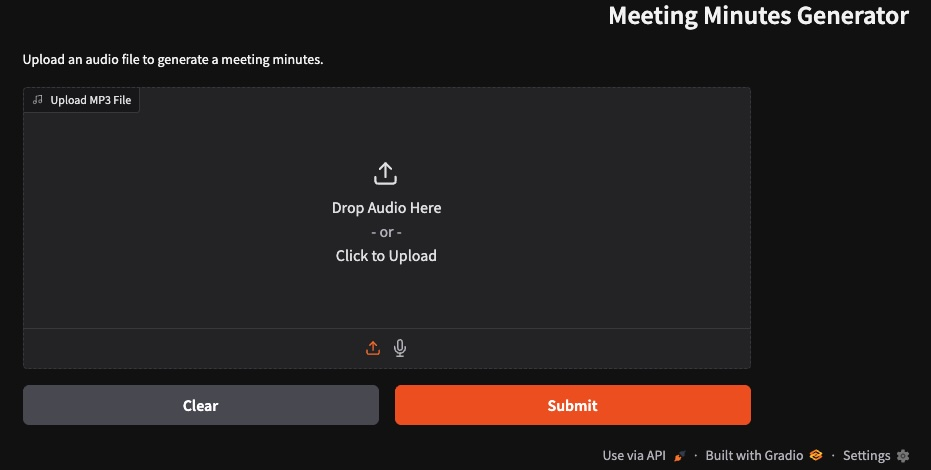


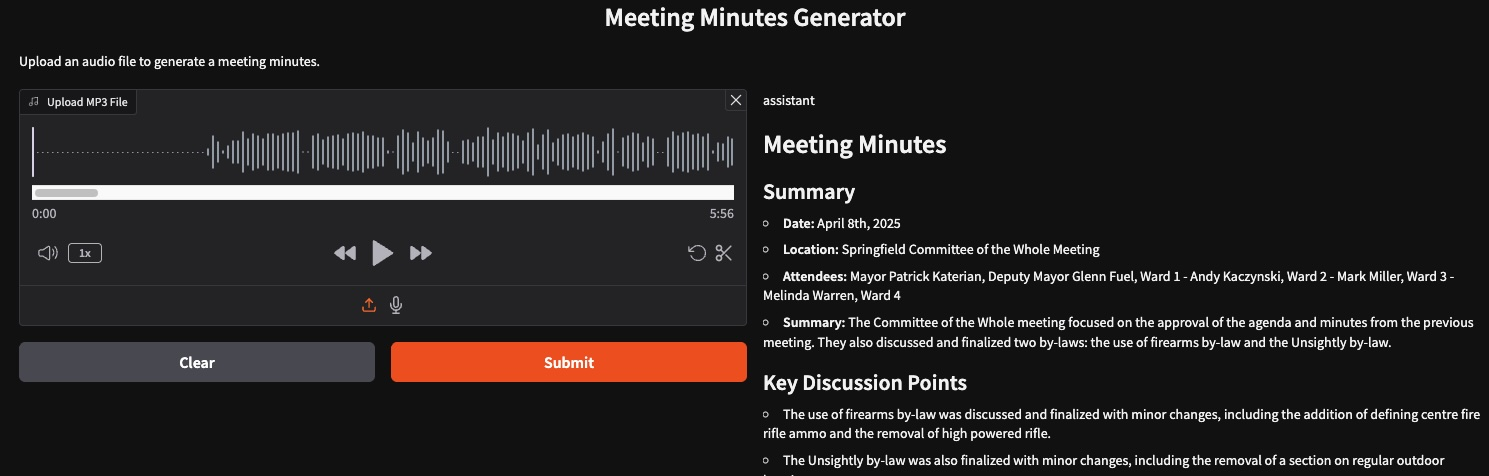
